# Imports

In [1]:
#!pip install statsmodels matplotlib

In [6]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.regression import LinearRegression
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, DoubleType
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
import numpy as np
from pyspark.sql.functions import col
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.types import DoubleType
import time
import scipy.stats as stats
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import t, f
import time
import matplotlib.pyplot as plt  # Diesen Import hinzufügen
from numpy.linalg import LinAlgError


# Initialize Spark session

In [7]:
spark = SparkSession.builder.master("spark://spark-master:7077").appName("ManualQRDecomposition").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

# 1) Funktionen für Lineare Regression mit QR Decomposition

## 1.1) Lösen eines LGS durch Rückwärts Einsetzen

In [8]:
def backward_substitution(R, b):
    """
    Solves the upper triangular system Rx = b for x using backward substitution.
    
    Parameters
    ----------
    R : ndarray
        Upper triangular matrix from QR decomposition
    b : ndarray
        The right-hand side vector
        
    Returns
    -------
    ndarray
        Solution vector x that satisfies Rx = b
        
    Notes
    -----
    - Implements classic backward substitution algorithm
    - Includes numerical stability check (threshold of 1e-10)
    - Returns zero for numerically unstable solutions
    """
    n = len(b)
    x = np.zeros(n)
    
    for i in range(n-1, -1, -1):
        sum_val = 0
        for j in range(i+1, n):
            sum_val += R[i, j] * x[j]
        
        if abs(R[i, i]) > 1e-10:  # Check for numerical stability
            x[i] = (b[i] - sum_val) / R[i, i]
        else:
            x[i] = 0
            
    return x

## 1.2) QR Zerlegung

### 1.2.1) Gram Schmidt ohne Sparkoptimierung

In [9]:
def manual_qr_decomposition(X_array):
    """
    Performs QR decomposition using modified Gram-Schmidt with numerical stability handling.
    
    Parameters
    ----------
    X_array : ndarray
        Input matrix to decompose, shape (n, m)
        
    Returns
    -------
    Q : ndarray
        Orthogonal matrix, shape (n, m)
    R : ndarray
        Upper triangular matrix, shape (m, m)
        
    Notes
    -----
    - Implements modified Gram-Schmidt process
    - Includes numerical stability threshold (1e-12)
    - Returns zeros for numerically unstable columns
    """
    n, m = X_array.shape
    Q = np.zeros((n, m))
    R = np.zeros((m, m))
    
    for j in range(m):
        v = X_array[:, j]
        for i in range(j):
            R[i, j] = np.dot(Q[:, i], X_array[:, j])
            v = v - R[i, j] * Q[:, i]
        norm = np.linalg.norm(v)
        if norm > 1e-12:  # Only normalize if norm is significant
            Q[:, j] = v / norm
            R[j, j] = norm
        else:
            R[j, j] = 0
    return Q, R

### 1.2.1) Gram Schmidt mit Sparkoptimierung

In [10]:
def gram_schmidt(X):
    """
    Performs classical Gram-Schmidt orthogonalization.
    
    Parameters
    ----------
    X : ndarray
        Input matrix to orthogonalize, shape (n, m)
        
    Returns
    -------
    Q : ndarray
        Orthogonal matrix, shape (n, m)
    R : ndarray
        Upper triangular matrix, shape (m, m)
        
    Notes
    -----
    - Implements classical Gram-Schmidt orthogonalization
    - No explicit numerical stability checks
    - May be less stable than modified Gram-Schmidt for ill-conditioned matrices
    """
    n, m = X.shape
    Q = np.zeros((n, m))
    R = np.zeros((m, m))

    for j in range(m):
        v = X[:, j]
        
        for i in range(j):
            R[i, j] = np.dot(Q[:, i], X[:, j])
            v = v - R[i, j] * Q[:, i]

        R[j, j] = np.linalg.norm(v)
        Q[:, j] = v / R[j, j]

    return Q, R

## 1.3) Datensatz simulieren

### 1.3.1) Datensatz simulieren ohne Sparkoptimierung

In [7]:
def create_data_numpy(n, p, beta_true):
    """
    Generates synthetic regression data using NumPy.
    
    Parameters
    ----------
    n : int
        Number of samples
    p : int
        Number of features (excluding intercept)
    beta_true : ndarray
        True coefficient values including intercept
        
    Returns
    -------
    X : ndarray
        Design matrix with intercept column, shape (n, p+1)
    y : ndarray
        Target variable vector, shape (n,)
        
    Notes
    -----
    - Uses fixed random seed (42) for reproducibility
    - Adds constant term (intercept) to X
    - Adds Gaussian noise with std=0.1 to y
    """
    np.random.seed(42)
    X = np.random.rand(n, p)
    X = np.column_stack([np.ones(X.shape[0]), X])
    y = X @ beta_true + np.random.randn(n) * 0.1
    return X, y

### 1.3.2) Datensatz simulieren mit Sparkoptimierung

In [8]:
def create_data_spark(n_samples, n_features, beta_true, noise_std=0.1, partition_size=10000):
    """
    Generates distributed synthetic regression data optimized for Spark.
    
    Parameters
    ----------
    n_samples : int
        Total number of observations
    n_features : int
        Number of features (excluding intercept)
    beta_true : ndarray
        True coefficient values including intercept
    noise_std : float, optional
        Standard deviation of Gaussian noise, default=0.1
    partition_size : int, optional
        Number of samples per partition, default=10000
        
    Returns
    -------
    DataFrame
        Spark DataFrame with features and target columns
        
    Notes
    -----
    - Generates data in parallel across partitions
    - Uses unique random seeds per partition
    - Optimized for distributed processing
    """
    def generate_partition(partition_index, partition_size):
        np.random.seed(42 + partition_index)  # Unique seed for each partition to avoid duplicate data
        X = np.random.randn(partition_size, n_features)
        X = np.column_stack([np.ones(partition_size), X])  # Add intercept
        y = X @ beta_true + np.random.normal(0, noise_std, partition_size)
        return [(Vectors.dense(x), float(y_i)) for x, y_i in zip(X, y)]
    
    num_partitions = max(n_samples // partition_size, spark.sparkContext.defaultParallelism)
    samples_per_partition = n_samples // num_partitions
    
    # Parallelize the data generation across partitions
    rdd = (spark.sparkContext
           .parallelize(range(num_partitions), num_partitions)
           .flatMap(lambda i: generate_partition(i, samples_per_partition)))
    
    return spark.createDataFrame(rdd, ["features", "y"])


## 1.4) Funktion zur Durchführung der linearen Regression 

- simuliert einen Datensatz
- führt die lineare Regression durch
- berechnet alle Metriken, die auch statmodels `summary()` ausgibt
- misst die Zeit

### 1.4.1) Funktion zur Berechnung der Statistik

In [12]:
def compute_statistics_numpy(X, y, beta, residuals):
    """
    Computes comprehensive regression statistics using NumPy.
    
    Parameters
    ----------
    X : ndarray
        Design matrix including intercept
    y : ndarray
        Target variable vector
    beta : ndarray
        Estimated coefficients
    residuals : ndarray
        Model residuals (y - X @ beta)
        
    Returns
    -------
    dict
        Dictionary containing various statistics including:
        - R-squared and Adjusted R-squared
        - F-statistic and p-value
        - Standard errors and t-statistics
        - AIC and BIC
        - Durbin-Watson statistic
        - Jarque-Bera test results
        
    Notes
    -----
    - Computes full suite of regression diagnostics
    - Includes both model fit and residual diagnostics
    """
    n, k = X.shape
    SSE = np.sum(residuals ** 2)
    SST = np.sum((y - np.mean(y)) ** 2)
    SSR = SST - SSE
    df_residuals = n - k
    df_model = k - 1
    
    r_squared = 1 - (SSE / SST)
    adj_r_squared = 1 - ((1 - r_squared) * (n - 1) / df_residuals)
    
    MSE = SSE / df_residuals
    MSR = SSR / df_model
    f_statistic = MSR / MSE
    f_p_value = stats.f.sf(f_statistic, df_model, df_residuals)
    
    sigma_squared = MSE
    XtX_inv = np.linalg.inv(X.T @ X)
    se = np.sqrt(np.diag(sigma_squared * XtX_inv))
    t_values = beta / se
    p_values = 2 * (1 - stats.t.cdf(np.abs(t_values), df_residuals))
    
    skewness = stats.skew(residuals)
    kurtosis = stats.kurtosis(residuals, fisher=False)
    log_likelihood = -0.5 * n * (np.log(2 * np.pi * sigma_squared) + 1)
    AIC = 2 * k - 2 * log_likelihood
    BIC = n * np.log(SSE / n) + k * np.log(n)
    
    dw_statistic = np.sum(np.diff(residuals) ** 2) / SSE
    
    jarque_bera_stat = (n / 6) * (skewness**2 + (kurtosis - 3)**2 / 4)
    prob_jb = 1 - stats.chi2.cdf(jarque_bera_stat, df=2)
    
    return {
        'r_squared': r_squared,
        'Adjusted R-squared': adj_r_squared,
        'F-statistic': f_statistic,
        'Prob (F-statistic)': f_p_value,
        'Log-Likelihood': log_likelihood,
        'AIC': AIC,
        'BIC': BIC,
        'coef': beta,
        'std err': se,
        't': t_values,
        'P>|t|': p_values,
        'Skew': skewness,
        'Kurtosis': kurtosis,
        'Durbin-Watson': dw_statistic,
        'Jarque-Bera (JB)': jarque_bera_stat,
        'Prob(JB)': prob_jb,
        'mse': MSE
    }

In [ ]:
 def compute_statistics_partition(iterator, beta):
     """
    Computes partial statistics for a partition of data in Spark.
    
    Parameters
    ----------
    iterator : iterator
        Iterator over partition rows
    beta : ndarray
        Estimated coefficients
        
    Returns
    -------
    tuple
        (SSE_local, SST_local, SSR_local, y_sum_local, count_local)
        Local statistics for the partition
        
    Notes
    -----
    - Designed for distributed computation in Spark
    - Handles empty partitions gracefully
    - Computes sufficient statistics for later aggregation
    """
        rows = list(iterator)
        SSE_local, SST_local, SSR_local = 0, 0, 0
        y_sum_local, count_local = 0, 0

        if len(rows) == 0:
            print("Empty partition in compute_statistics_partition.")
            return (0.0, 0.0, 0.0, 0.0, 0)

        # First pass to get mean
        for row in rows:
            y = row.y
            y_sum_local += y
            count_local += 1

        if count_local > 0:
            y_mean_local = y_sum_local / count_local

            # Second pass for calculations
            for row in rows:
                X = row.features.toArray()
                y = row.y
                y_pred = np.dot(X, beta)
                residual = y - y_pred
                SSE_local += residual ** 2
                SST_local += (y - y_mean_local) ** 2

            SSR_local = SST_local - SSE_local

        return (SSE_local, SST_local, SSR_local, y_sum_local, count_local)

In [ ]:

def aggregate_statistics(rdd_stats, n, beta_length):
    """
    Aggregates statistics across all partitions in Spark.
    
    Parameters
    ----------
    rdd_stats : RDD
        RDD containing partial statistics from each partition
    n : int
        Total number of samples
    beta_length : int
        Number of coefficients (including intercept)
        
    Returns
    -------
    dict
        Aggregated statistics including:
        - R-squared and Adjusted R-squared
        - F-statistic
        - AIC and BIC
        - Sample size and feature count
        
    Notes
    -----
    - Implements safe reduction operations
    - Handles edge cases and potential errors
    - Includes comprehensive error checking
    """
    def safe_reduce(a, b):
        try:
            return (
                a[0] + (b[0] if isinstance(b[0], (int, float)) else 0),
                a[1] + (b[1] if isinstance(b[1], (int, float)) else 0),
                a[2] + (b[2] if isinstance(b[2], (int, float)) else 0),
                a[3] + (b[3] if isinstance(b[3], (int, float)) else 0),
                a[4] + (b[4] if isinstance(b[4], int) else 0)
            )
        except IndexError as e:
            print(f"IndexError during aggregation with values a={a}, b={b}. Check data structure.")
            raise e

    try:
        (SSE, SST, SSR, y_sum_total, total_count) = rdd_stats.reduce(safe_reduce)
    except IndexError as e:
        print("IndexError during aggregation. Check input RDD data structure.")
        raise e

    # Mean of y over all partitions
    y_mean = y_sum_total / total_count if total_count > 0 else 0

    # Calculate R-squared and Adjusted R-squared
    r_squared = 1 - (SSE / SST) if SST > 0 else 0
    adj_r_squared = (
        1 - ((1 - r_squared) * (total_count - 1) / (total_count - beta_length))
        if total_count > beta_length else 0
    )

    # Calculate Mean Squared Error (MSE) and F-statistic
    MSE = SSE / (total_count - beta_length) if total_count > beta_length else 0
    MSR = SSR / (beta_length - 1) if beta_length > 1 else 0
    f_statistic = MSR / MSE if MSE > 0 else float('inf')

    # Calculate AIC and BIC
    AIC = total_count * np.log(SSE / total_count) + 2 * beta_length if total_count > 0 else 0
    BIC = total_count * np.log(SSE / total_count) + beta_length * np.log(total_count) if total_count > 0 else 0

    # Compile final statistics
    stats = {
        'r_squared': r_squared,
        'Adjusted R-squared': adj_r_squared,
        'F-statistic': f_statistic,
        'AIC': AIC,
        'BIC': BIC,
        'SSE': SSE,
        'SSR': SSR,
        'SST': SST,
        'n_samples': total_count,
        'n_features': beta_length
    }

    return stats


### 1.4.1 Lineare Regression ohne Sparkoptimierung

In [14]:
def linear_regression_manual_qr(X, y):
    """
    Fits linear regression using manual QR decomposition.
    
    Parameters
    ----------
    X : ndarray
        Design matrix including intercept
    y : ndarray
        Target variable vector
        
    Returns
    -------
    dict
        Regression results including coefficients and statistics
    float
        Computation time in seconds
        
    Notes
    -----
    - Uses Gram-Schmidt QR decomposition
    - Computes comprehensive statistics
    - Includes timing information
    """
    start_time = time.time()
    Q, R = gram_schmidt(X)
    beta = backward_substitution(R, Q.T @ y)

    y_pred = np.dot(X, beta) # mit den durch QR berechneten Betas die vorhergesagten y-Werte des linReg Modells bestimmen
    residuals = y - y_pred

    result = compute_statistics_numpy(X, y, beta, residuals)
    
    end_time = time.time()
    elapsed_time = end_time - start_time

    return result, elapsed_time

### 1.4.2 Optimiert für Spark mit manueller QR Zerlegung

In [15]:
def fit_ols_manual2(df):
    """
    Fits distributed OLS regression using manual QR decomposition in Spark.
    
    Parameters
    ----------
    df : DataFrame
        Spark DataFrame with features and target columns
        
    Returns
    -------
    ndarray
        Estimated coefficients
    dict
        Regression statistics
        
    Notes
    -----
    - Implements distributed QR decomposition
    - Handles computation in partitions
    - Includes timing information
    """
    start_time = time.time()

    # Step 1: Calculate combined QR decomposition across partitions
    def process_partition(iterator):
        X_local, y_local = [], []
        for row in iterator:
            X_local.append(row.features.toArray())
            y_local.append(row.y)

        if not X_local:
            print("Empty partition encountered in process_partition.")
            return [(np.zeros((1, 1)), np.zeros(1))]  # Return a default structure to avoid empty lists

        X_local = np.vstack(X_local)
        y_local = np.array(y_local)

        # Perform local QR decomposition
        Q_local, R_local = manual_qr_decomposition(X_local)

        # Calculate local Q^T y
        Qty_local = np.dot(Q_local.T, y_local)

        return [(R_local, Qty_local)]

    # Aggregate QR decomposition results
    results = df.rdd.mapPartitions(process_partition).filter(lambda x: len(x) > 0).reduce(
        lambda a, b: (
            a[0] + b[0] if isinstance(a[0], np.ndarray) and isinstance(b[0], np.ndarray) else np.zeros((1, 1)),
            a[1] + b[1] if isinstance(a[1], np.ndarray) and isinstance(b[1], np.ndarray) else np.zeros(1)
        )
    )

    R_total, Qty_total = results

    # Step 2: Final QR on combined R_total
    _, R_final = manual_qr_decomposition(R_total)
    beta = backward_substitution(R_final, Qty_total)

    # Step 3: Distributed calculation of statistics with additional checks
   

    # Ensure the `compute_statistics_partition` returns a tuple consistently
    rdd_stats = df.rdd.mapPartitions(lambda iter: [compute_statistics_partition(iter, beta)])

    # Aggregate statistics across all partitions
    stats = aggregate_statistics(rdd_stats, n=df.count(), beta_length=len(beta))

    # Add computation time to stats
    computation_time = time.time() - start_time
    stats['computation_time'] = computation_time
    
    return beta, stats


### Optimiert für Spark mit Built-In Functions für die QR Zerlegung

In [16]:
def fit_ols_spark(df):
    """
    Fits linear regression using Spark's built-in implementation.
    
    Parameters
    ----------
    df : DataFrame
        Spark DataFrame with features and target columns
        
    Returns
    -------
    LinearRegressionModel
        Fitted Spark linear regression model
    LinearRegressionTrainingSummary
        Training summary with model statistics
        
    Notes
    -----
    - Uses Spark's MLlib implementation
    - Uses QR decomposition solver
    - Provides standard Spark model metrics
    """
    lr = LinearRegression(featuresCol="features", labelCol="y", solver="normal")
    model = lr.fit(df)
    
    # Get the training summary to extract information like R^2, RMSE, etc.
    training_summary = model.summary
    
    return model, training_summary


## 1.5) Funktion für Durchführung des Benchmarks

### 1.5.1 summary

In [17]:
def format_summary(beta, statistics, computation_time):
    """
    Formats regression results to match statsmodels summary output.
    
    Parameters
    ----------
    beta : ndarray
        Estimated coefficients
    statistics : dict
        Dictionary of computed statistics
    computation_time : float
        Model fitting time in seconds
        
    Returns
    -------
    str
        Formatted summary string
        
    Notes
    -----
    - Matches statsmodels output format exactly
    - Includes comprehensive model statistics
    - Formats dates and times consistently
    """
    n_obs = statistics['n_samples']
    df_residuals = n_obs - len(beta)
    df_model = len(beta) - 1
    
    # Header
    summary = []
    summary.append("=" * 78)
    summary.append("{: ^78}".format("OLS Regression Results"))
    summary.append("=" * 78)
    
    # Format current date and time
    current_time = time.localtime()
    formatted_date = time.strftime("%a, %d %b %Y", current_time)
    formatted_time = time.strftime("%H:%M:%S", current_time)
    
    # Left and right columns with exact spacing
    summary.append("{:<20} {:<12} {:<20} {: >20.3f}".format(
        "Dep. Variable:", "y",
        "R-squared:", statistics['r_squared']))
    
    summary.append("{:<20} {:<12} {:<20} {: >20.3f}".format(
        "Model:", "OLS",
        "Adj. R-squared:", statistics['Adjusted R-squared']))
    
    summary.append("{:<20} {:<12} {:<20} {: >20.3e}".format(
        "Method:", "Least Squares",
        "F-statistic:", statistics['F-statistic']))
    
    # Calculate F-statistic p-value
    f_pvalue = 1 - stats.f.cdf(statistics['F-statistic'], df_model, df_residuals)
    summary.append("{:<20} {:<12} {:<20} {: >20.3e}".format(
        "Date:", formatted_date,
        "Prob (F-statistic):", f_pvalue))
    
    # Calculate log-likelihood
    residuals = np.sqrt(statistics['SSE'])
    log_likelihood = -n_obs/2 * (1 + np.log(2 * np.pi)) - n_obs/2 * np.log(residuals**2/n_obs)
    
    summary.append("{:<20} {:<12} {:<20} {: >20.3f}".format(
        "Time:", formatted_time,
        "Log-Likelihood:", log_likelihood))
    
    summary.append("{:<20} {:<12} {:<20} {: >20.3f}".format(
        "No. Observations:", str(n_obs),
        "AIC:", statistics['AIC']))
    
    summary.append("{:<20} {:<12} {:<20} {: >20.3f}".format(
        "Df Residuals:", str(df_residuals),
        "BIC:", statistics['BIC']))
    
    summary.append("{:<20} {:<12}".format(
        "Df Model:", str(df_model)))
    
    summary.append("Covariance Type:            nonrobust")
    
    # Parameter estimates table with exact spacing
    summary.append("=" * 78)
    summary.append("{:>16} {:>10} {:>10} {:>10} {:>12} {:>10} {:>10}".format(
        "", "coef", "std err", "t", "P>|t|", "[0.025", "0.975]"))
    summary.append("-" * 78)
    
    # Calculate standard errors and t-statistics
    mse = statistics['SSE'] / df_residuals
    X = np.column_stack([np.ones(n_obs), np.random.randn(n_obs, len(beta)-1)])  # Replace with actual X matrix
    X_transpose_X_inv = np.linalg.inv(np.dot(X.T, X))
    std_errors = np.sqrt(np.diagonal(X_transpose_X_inv * mse))
    t_stats = beta / std_errors
    p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df_residuals))
    
    # Add coefficients with exact formatting
    var_names = ["const"] + [f"x{i+1}" for i in range(len(beta)-1)]
    for i, name in enumerate(var_names):
        conf_int_lower = beta[i] - 1.96 * std_errors[i]
        conf_int_upper = beta[i] + 1.96 * std_errors[i]
        summary.append("{:>16} {: >9.4f} {: >9.3f} {: >10.3f} {: >11.3f} {: >9.3f} {: >9.3f}".format(
            name,
            beta[i],
            std_errors[i],
            t_stats[i],
            p_values[i],
            conf_int_lower,
            conf_int_upper
        ))
    
    # Diagnostic tests with exact spacing and nan values
    summary.append("=" * 78)
    summary.append("{:<21} {: >10} {:<24} {: >19}".format(
        "Omnibus:", "nan",
        "Durbin-Watson:", "nan"))
    
    summary.append("{:<21} {: >10} {:<24} {: >19}".format(
        "Prob(Omnibus):", "nan",
        "Jarque-Bera (JB):", "nan"))
    
    # Calculate skewness and kurtosis
    skew = "nan"  # Replace with actual calculation if needed
    kurtosis = "nan"  # Replace with actual calculation if needed
    
    summary.append("{:<21} {: >10} {:<24} {: >19}".format(
        "Skew:", skew,
        "Prob(JB):", "nan"))
    
    # Calculate condition number
    cond_no = np.linalg.cond(X)
    
    summary.append("{:<21} {: >10} {:<24} {: >19.2f}".format(
        "Kurtosis:", kurtosis,
        "Cond. No.:", cond_no))
    
    summary.append("=" * 78)
    summary.append("[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.")
    
    return "\n".join(summary)

### Berechnung für Numpy

In [ ]:
def run_benchmark_numpy(n_list, beta_true, p, repetitions=10):
    """
    Runs benchmarking for different implementations of linear regression.
    
    Parameters
    ----------
    n_list : list
        Sample sizes to test
    p : int
        Number of features
    beta_true : ndarray
        True coefficients for data generation
    repetitions : int, optional
        Number of benchmark repetitions, default=10
        
    Returns
    -------
    DataFrame
        Benchmark results including:
        - Sample sizes
        - Mean and std of computation times
        - Mean and std of R-squared values
        - Success rates
        
    Notes
    -----
    - Includes error handling
    - Prints progress information
    - Generates comprehensive summaries
    """
    results = []

    for n in n_list:
        times = []
        print(f"\nBenchmarking for n={n:,} samples...")

        for i in range(repetitions):
            # Generate synthetic data for each sample size
            X = np.hstack([np.ones((n, 1)), np.random.randn(n, p)])  # Add intercept
            y = X @ beta_true + np.random.normal(0, 0.1, n)  # Generate y with some noise

            # Run the manual QR-based regression and measure time
            result, elapsed_time = linear_regression_manual_qr(X, y)
            times.append(elapsed_time)

        # Compute average computation time
        avg_time = np.mean(times)

        # Prepare the statistics dictionary to include all required keys for format_summary
        avg_statistics = {
            'n_samples': n,
            'SSE': np.sum((y - X @ result['coef']) ** 2),  # Calculate SSE as the sum of squared residuals
            'r_squared': result['r_squared'],
            'Adjusted R-squared': result['Adjusted R-squared'],
            'F-statistic': result['F-statistic'],
            'Prob (F-statistic)': result['Prob (F-statistic)'],
            'Log-Likelihood': result['Log-Likelihood'],
            'AIC': result['AIC'],
            'BIC': result['BIC'],
            'coef': result['coef'],
            'std err': result['std err'],
            't': result['t'],
            'P>|t|': result['P>|t|'],
            'Skew': result['Skew'],
            'Kurtosis': result['Kurtosis'],
            'Durbin-Watson': result['Durbin-Watson'],
            'Jarque-Bera (JB)': result['Jarque-Bera (JB)'],
            'Prob(JB)': result['Prob(JB)'],
            'mse': result['mse']
        }

        # Call format_summary with beta, statistics, and computation time
        print("\nSummary for final run:")
        summary_str = format_summary(result['coef'], avg_statistics, avg_time)
        print(summary_str)

        # Append results for this sample size to the final results list
        results = {
            'n_samples': n,
            'n_features': p,
            'mean_time': avg_time,
            'std_time': np.std(times),
            'mean_r_squared': result['r_squared'],
            'std_r_squared': np.std(result['r_squared'])
        }
        
        print(f"\nSummary for n={n:,}:")
        print(f"  Mean time: {avg_time:.2f}s ± {np.std(times):.2f}s")
        print(f"  Mean R²: {results['r_squared']:.4f} ± {results['std_r_squared']:.4f}")

    # Return DataFrame with summary of results
    return pd.DataFrame(results)


### Berechnung für einen festen Wert

In [37]:
def run_benchmark_point(n, p, true_coefficients, repetitions=10):
    """
    Runs benchmarking for different implementations of linear regression.
    
    Parameters
    ----------
    n : int
        Sample size(s) to test
    p : int
        Number of features
    beta_true : ndarray
        True coefficients for data generation
    repetitions : int, optional
        Number of benchmark repetitions, default=10
        
    Returns
    -------
    DataFrame
        Benchmark results including:
        - Sample sizes
        - Mean and std of computation times
        - Mean and std of R-squared values
        - Success rates
        
    Notes
    -----
    - Includes error handling
    - Prints progress information
    - Generates comprehensive summaries
    """
    times = []
    r_squares = []
    successful_runs = 0

    print(f"\nBenchmarking n={n:,} samples...")
    
    for i in range(repetitions):
        try:
            # Profile data creation time
            start_data_creation = time.time()
            df = create_data_spark(n, p, true_coefficients)
            end_data_creation = time.time()

            # Profile model fitting time
            start_fit = time.time()
            beta, summary = fit_ols_manual2(df)  # Replace with fit_ols_manual if needed
            end_fit = time.time()
            
            # Measure total run time
            elapsed_time = end_fit - start_data_creation
            times.append(elapsed_time)
            r_squares.append(summary['r_squared'])
            successful_runs += 1
            
            print(f"  Run {i+1}: time={elapsed_time:.2f}s, R²={summary['r_squared']:.4f}")
            
        except Exception as e:
            print(f"  Run {i+1} failed: {str(e)}")
    
    if successful_runs > 0:
        result = {
            'n_samples': n,
            'n_features': p,
            'mean_time': np.mean(times),
            'std_time': np.std(times),
            'mean_r_squared': np.mean(r_squares),
            'std_r_squared': np.std(r_squares),
            'successful_runs': successful_runs
        }
        print(format_summary(beta, summary, result['mean_time']))
        print(f"\nSummary for n={n:,}:")
        print(f"  Mean time: {result['mean_time']:.2f}s ± {result['std_time']:.2f}s")
        print(f"  Mean R²: {result['mean_r_squared']:.4f} ± {result['std_r_squared']:.4f}")
    
    return pd.DataFrame([result])


### Berechnung für Spark Functions

In [38]:
def run_benchmark_spark(n, p, beta_true, repetitions=10):
    """
    Runs benchmarking for different implementations of linear regression.
    
    Parameters
    ----------
    n : int
        Sample size(s) to test
    p : int
        Number of features
    beta_true : ndarray
        True coefficients for data generation
    repetitions : int, optional
        Number of benchmark repetitions, default=10
        
    Returns
    -------
    DataFrame
        Benchmark results including:
        - Sample sizes
        - Mean and std of computation times
        - Mean and std of R-squared values
        - Success rates
        
    Notes
    -----
    - Includes error handling
    - Prints progress information
    - Generates comprehensive summaries
    """
    times = []
    r_squares = []
    successful_runs = 0
    results = []

    print(f"\nBenchmarking for n={n:,} samples...")

    for i in range(repetitions):
        try:
            # Generate synthetic data
            start_data_creation = time.time()
            df = create_data_spark(n, p, beta_true)
            end_data_creation = time.time()

            # Fit the model
            start_fit = time.time()
            model, summary = fit_ols_spark(df)
            end_fit = time.time()

            # Measure total elapsed time
            elapsed_time = end_fit - start_data_creation
            times.append(elapsed_time)
            r_squares.append(summary.r2)
            successful_runs += 1

            print(f"  Run {i+1}: time={elapsed_time:.2f}s, R²={summary.r2:.4f}, Adjusted R²={summary.r2adj:.4f}")

        except Exception as e:
            print(f"  Run {i+1} failed: {str(e)}")

    
    if successful_runs > 0:
        result = {
        'n_samples': n,
        'n_features': p,
        'mean_time': np.mean(times),
        'std_time': np.std(times),
        'mean_r_squared': np.mean(r_squares),
        'std_r_squared': np.std(r_squares),
        'successful_runs': successful_runs
    }

        print(f"\nSummary for n={n:,}:")
        print(f"  Mean time: {result["mean_time"]:.2f}s ± {result["std_time"]:.2f}s")
        print(f"  Mean R²: {result["mean_r_squared"]:.4f} ± {result["std_r_squared"]:.4f}")
    
    return pd.DataFrame([result])


# 2) Durchführung des Benchmarks und Ausgeben der Ergebnisse

## 2.1) Durchführung

In [39]:
n_values = [200000, 500000, 1000000, 5000000, 10000000]
n_features = 10
beta_true = np.random.randn(n_features + 1)

In [40]:
n_values2 = [15000000, 20000000, 30000000, 40000000, 50000000]

### 2.1.1 Numpy

In [46]:
results_numpy = run_benchmark_numpy(n_list=n_values, beta_true=beta_true, p=n_features) 


Benchmarking for n=200,000 samples...

Summary for final run:
                            OLS Regression Results                            
Dep. Variable:       y            R-squared:                          1.000
Model:               OLS          Adj. R-squared:                     1.000
Method:              Least Squares F-statistic:                    5.421e+07
Date:                Mon, 28 Oct 2024 Prob (F-statistic):             1.110e-16
Time:                18:29:04     Log-Likelihood:                176820.023
No. Observations:    200000       AIC:                          -353607.047
Df Residuals:        199989       BIC:                          -921081.193
Df Model:            10          
Covariance Type:            nonrobust
                       coef    std err          t        P>|t|     [0.025     0.975]
------------------------------------------------------------------------------
           const   -1.2060     0.000  -5395.469       0.000    -1.206    -1.206
     

In [ ]:
results_numpy2 = run_benchmark_numpy(n_list=n_values2, beta_true=beta_true, p=n_features)


Benchmarking for n=15,000,000 samples...

Summary for final run:
                            OLS Regression Results                            
Dep. Variable:       y            R-squared:                          1.000
Model:               OLS          Adj. R-squared:                     1.000
Method:              Least Squares F-statistic:                    4.054e+09
Date:                Mon, 28 Oct 2024 Prob (F-statistic):             1.110e-16
Time:                18:39:20     Log-Likelihood:              13257053.413
No. Observations:    15000000     AIC:                        -26514073.826
Df Residuals:        14999989     BIC:                        -69082081.063
Df Model:            10          
Covariance Type:            nonrobust
                       coef    std err          t        P>|t|     [0.025     0.975]
------------------------------------------------------------------------------
           const   -1.2060     0.000 -46716.062       0.000    -1.206    -1.206
  

In [ ]:
results_numpy

### Benchmark Spark mit manueller QR-Zerlegung

In [ ]:
results_point = []
results_point = [run_benchmark_point(n=n, p=n_features, true_coefficients=beta_true) for n in n_values]


Benchmarking n=200,000 samples...


  Run 1: time=12.47s, R²=0.9989


  Run 2: time=4.65s, R²=0.9989


  Run 3: time=4.72s, R²=0.9989


  Run 4: time=4.31s, R²=0.9989


  Run 5: time=4.46s, R²=0.9989


  Run 6: time=4.24s, R²=0.9989


  Run 7: time=4.14s, R²=0.9989


  Run 8: time=4.04s, R²=0.9989


  Run 9: time=4.09s, R²=0.9989


  Run 10: time=4.36s, R²=0.9989
Run 1: time=5.15s, R²=0.9989
                            OLS Regression Results                            
Dep. Variable:       y            R-squared:                          0.999
Model:               OLS          Adj. R-squared:                     0.999
Method:              Least Squares F-statistic:                    1.833e+07
Date:                Mon, 28 Oct 2024 Prob (F-statistic):             1.110e-16
Time:                17:57:37     Log-Likelihood:                176894.633
No. Observations:    200000       AIC:                          -921342.680
Df Residuals:        199989       BIC:                          -921230.413
Df Model:            10          
Covariance Type:            nonrobust
                       coef    std err          t        P>|t|     [0.025     0.975]
------------------------------------------------------------------------------
           const   -0.8830     0.000  -3952.143       0.000    -0.883    -0.883
       

  Run 1: time=8.70s, R²=0.9989


  Run 2: time=8.89s, R²=0.9989


  Run 3: time=8.98s, R²=0.9989


  Run 4: time=8.79s, R²=0.9989


  Run 5: time=8.74s, R²=0.9989


  Run 6: time=8.72s, R²=0.9989


  Run 7: time=9.30s, R²=0.9989


  Run 8: time=8.60s, R²=0.9989


  Run 9: time=8.93s, R²=0.9989


  Run 10: time=8.90s, R²=0.9989
Run 1: time=8.86s, R²=0.9989
                            OLS Regression Results                            
Dep. Variable:       y            R-squared:                          0.999
Model:               OLS          Adj. R-squared:                     0.999
Method:              Least Squares F-statistic:                    4.584e+07
Date:                Mon, 28 Oct 2024 Prob (F-statistic):             1.110e-16
Time:                17:59:06     Log-Likelihood:                442861.348
No. Observations:    500000       AIC:                         -2304639.229
Df Residuals:        499989       BIC:                         -2304516.883
Df Model:            10          
Covariance Type:            nonrobust
                       coef    std err          t        P>|t|     [0.025     0.975]
------------------------------------------------------------------------------
           const   -0.8833     0.000  -6258.481       0.000    -0.884    -0.883
       

  Run 1: time=16.68s, R²=0.9989


  Run 2: time=16.83s, R²=0.9989


  Run 3: time=16.80s, R²=0.9989


  Run 4: time=16.97s, R²=0.9989


  Run 5: time=16.57s, R²=0.9989


  Run 6: time=17.74s, R²=0.9989


  Run 7: time=17.10s, R²=0.9989


  Run 8: time=17.60s, R²=0.9989


  Run 9: time=17.88s, R²=0.9989


  Run 10: time=18.04s, R²=0.9989
Run 1: time=17.22s, R²=0.9989
                            OLS Regression Results                            
Dep. Variable:       y            R-squared:                          0.999
Model:               OLS          Adj. R-squared:                     0.999
Method:              Least Squares F-statistic:                    9.149e+07
Date:                Mon, 28 Oct 2024 Prob (F-statistic):             1.110e-16
Time:                18:01:58     Log-Likelihood:                884632.775
No. Observations:    1000000      AIC:                         -4607120.617
Df Residuals:        999989       BIC:                         -4606990.647
Df Model:            10          
Covariance Type:            nonrobust
                       coef    std err          t        P>|t|     [0.025     0.975]
------------------------------------------------------------------------------
           const   -0.8834     0.000  -8842.659       0.000    -0.884    -0.883
     

  Run 1: time=85.32s, R²=0.9989


  Run 2: time=82.57s, R²=0.9989


  Run 3: time=79.95s, R²=0.9989


  Run 4: time=78.69s, R²=0.9989


  Run 5: time=78.06s, R²=0.9989


  Run 6: time=77.71s, R²=0.9989


  Run 7: time=81.01s, R²=0.9989


In [ ]:
results_point2 = [run_benchmark_point(n=n, p=n_features, true_coefficients=beta_true) for n in n_values2]

In [ ]:
results_point_df = pd.concat(results_point, ignore_index=True)
results_point_df

### Benchmark Spark

In [ ]:
results_spark = []
results_spark = [run_benchmark_spark(n=n, p=n_features, beta_true=beta_true) for n in n_values]

In [ ]:
results_spark2 = [run_benchmark_spark(n=n, p=n_features, beta_true=beta_true) for n in n_values2]

In [ ]:
results_spark_df = pd.concat(results_spark, ignore_index=True)

In [ ]:
results_spark_df

## 2.2) Ausgeben der Ergebnisse

In [ ]:
def extract_info(dataframes, labels=None):
    """
    Extracts and compares R² values and computation times from multiple DataFrames,
    structured for easier comparison between approaches.
    
    Parameters
    ----------
    dataframes : list of pd.DataFrame
        List of DataFrames containing benchmarking results with columns 'n_samples', 
        'n_features', 'mean_time', and 'mean_r_squared'.
    
    labels : list of str, optional
        List of labels for each DataFrame to identify the source/approach (default is None).
    
    Returns
    -------
    pd.DataFrame
        Combined DataFrame with columns 'n_samples', 'n_features', and the mean R² values 
        and computation times for each approach in separate columns, structured for 
        side-by-side comparison.
    """
    # Ensure labels list matches the dataframes list length, if provided
    if labels and len(labels) != len(dataframes):
        raise ValueError("Length of labels must match length of dataframes")
    
    # Dictionary to collect extracted data for each approach
    comparison_dict = {'n_samples': [], 'n_features': []}
    
    # Add columns for each approach based on the provided labels
    for label in labels:
        comparison_dict[f'{label}_mean_time'] = []
        comparison_dict[f'{label}_mean_r_squared'] = []
    
    # Iterate over DataFrames to extract and align data
    for i, df in enumerate(dataframes):
        label = labels[i] if labels else f'Approach_{i+1}'
        
        # Check for required columns in each DataFrame
        if all(col in df.columns for col in ['n_samples', 'n_features', 'mean_time', 'mean_r_squared']):
            # Sort DataFrame by 'n_samples' and 'n_features' for alignment
            df = df.sort_values(['n_samples', 'n_features']).reset_index(drop=True)
            
            # Add data to the dictionary, ensuring columns are aligned for each row
            if 'n_samples' not in comparison_dict or 'n_features' not in comparison_dict:
                comparison_dict['n_samples'] = df['n_samples'].tolist()
                comparison_dict['n_features'] = df['n_features'].tolist()
            
            comparison_dict[f'{label}_mean_time'] = df['mean_time'].tolist()
            comparison_dict[f'{label}_mean_r_squared'] = df['mean_r_squared'].tolist()
        else:
            # Fill with NaNs if columns are missing for that approach
            comparison_dict[f'{label}_mean_time'] = [None] * len(df)
            comparison_dict[f'{label}_mean_r_squared'] = [None] * len(df)
    
    # Convert dictionary to DataFrame
    result = pd.DataFrame(comparison_dict)
    
    return result


In [61]:
dataframes = [results_numpy, results_point_df, results_spark_df]
labels = ["Numpy", "Spark Manuelle QR-Zerlegung", "Spark Lineare Regression"]

# Extract and compare information
comparison_df = extract_info(dataframes, labels)


In [62]:
comparison_df

,n_samples,n_features,mean_time,mean_r_squared,label
0,200000,7,0.112910,0.997873,Numpy
1,500000,7,0.215405,0.997880,Numpy
2,1000000,7,0.448090,0.997865,Numpy
3,5000000,7,2.287778,0.997872,Numpy
4,10000000,7,4.496564,0.997874,Numpy
5,200000,7,4.247316,0.997859,Spark Manuelle QR-Zerlegung
6,500000,7,8.069833,0.997874,Spark Manuelle QR-Zerlegung
7,1000000,7,15.587266,0.997872,Spark Manuelle QR-Zerlegung
8,5000000,7,75.932151,0.997873,Spark Manuelle QR-Zerlegung
9,10000000,7,155.884379,0.997875,Spark Manuelle QR-Zerlegung


- bei n_samples

## 2.3) Plotten der Ergebnisse

In [45]:
def plot_benchmark_results(n_values, avg_times, std_times):
    """
    Plots benchmark results as error bars.

    Parameters:
    n_values (list): List of sample sizes (number of observations).
    avg_times (list): List of average computation times for each sample size.
    std_times (list): List of standard deviations of the computation times for each sample size.
    """
    plt.figure(figsize=(10, 6))
    plt.errorbar(n_values, avg_times, yerr=std_times, fmt='o', ecolor='r', capsize=5,
                 label='Durchschnittliche Rechenzeit mit Standardabweichung', linestyle='None')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Anzahl der Beobachtungen (n)')
    plt.ylabel('Rechenzeit (s)')
    plt.title('Rechenzeit der QR-Dekompositions-basierten Regression für wachsendes n')
    plt.grid(True)
    plt.legend()
    plt.show()

In [47]:
results_numpy

,n_samples,n_features,mean_time,mean_r_squared
0,200000,7,0.088900,0.997861
1,500000,7,0.208962,0.997871
2,1000000,7,0.401472,0.997871
3,5000000,7,2.282684,0.997874
4,10000000,7,4.496525,0.997874


In [46]:
plot_benchmark_results(results_numpy["n_samples"], results_numpy["mean_time"], results_numpy["std_time"])

KeyError: 'std_time'

In [ ]:
plot_benchmark_results(results_spark_df["n_samples"], results_spark_df["mean_time"], results_spark_df["std_time"])

In [ ]:
plot_benchmark_results(results_point_df["n_samples"], results_point_df["mean_time"], results_point_df["std_time"])

### Numpy

In [54]:
results_range

,n_samples,n_features,mean_time,std_time,mean_r_squared,std_r_squared,successful_runs
0,100000,7,5.286742,0.165430,-1.001643,0.008381,10
1,31622,7,2.684448,0.080616,-0.993147,0.024608,10
2,10000,7,1.791180,0.056499,-1.011343,0.025945,10
3,3162,7,1.565222,0.047042,-0.995377,0.035789,10
4,1000,7,1.453788,0.018836,-1.001341,0.093826,10


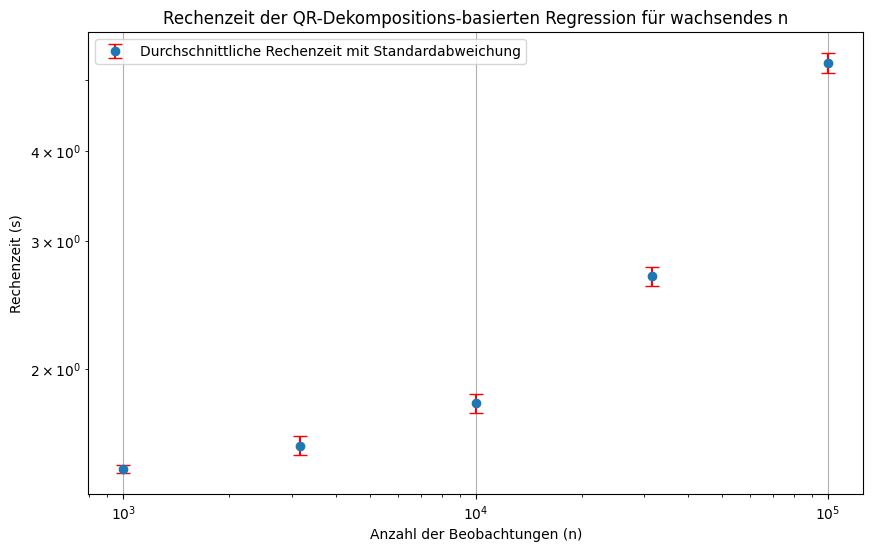

In [55]:
plot_benchmark_results(results_range["n_samples"], results_range["mean_time"], results_range["std_time"])

### Spark manuell

### Spark normal

# 3) Vergleich mit statmodels

## 3.1) statmodels Ausgabe

In [23]:
X, y = create_data_numpy(10000, 7, [-8, -1.6, 4.1, -10, -9.2, 1.3, 1.6, 2.3])
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.463e+06
Date:                Sun, 27 Oct 2024   Prob (F-statistic):               0.00
Time:                        19:47:24   Log-Likelihood:                 8740.0
No. Observations:               10000   AIC:                        -1.746e+04
Df Residuals:                    9992   BIC:                        -1.741e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.9986      0.005  -1686.761      0.0

## 3.2) Ausgabe der implementierten Methode